In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

In [25]:
from ditb.stitching.tiles import (get_tile_corners, numpy_shape_to_shapely, normalize_chunks, get_chunk_coordinates, 
                                  get_chunk_coordinates2, get_rect_from_chunk_boundary, find_chunk_tile_intersections,
                                  fuse_func)
from ditb.io.metadata import read_mmzarr_metadata, get_tile_coordinate, get_imshape, get_pixel_size, list_images
from ditb.io.imread import mmzarr_load_one_tile

from skimage.transform import AffineTransform
from shapely.geometry import GeometryCollection, Point

import numpy as np
from functools import partial

import dask
from dask.diagnostics import ProgressBar

In [3]:
test_data = '../../Notebooks/Est_map_40x_2_normalized.zarr/'
metadata = read_mmzarr_metadata(test_data)

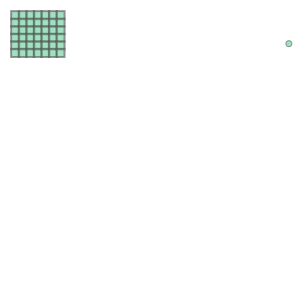

In [4]:
w, h = get_imshape(metadata)
pixum = get_pixel_size(metadata)
img_names = list_images(metadata)
coordinates = np.stack([get_tile_coordinate(tile, metadata) for tile in img_names])
transforms = [AffineTransform(translation=pos[::-1]/pixum).params for pos in coordinates]
tiles = [get_tile_corners(w, h, t) for t in transforms]
tiles_shapely = [numpy_shape_to_shapely(t) for t in tiles]

origin = Point(0,0)
GeometryCollection((origin, GeometryCollection(tiles_shapely)))

In [5]:
# Determine the size of all those tiles
all_bboxes = np.vstack(tiles)
all_min = all_bboxes.min(axis=0)
all_max = all_bboxes.max(axis=0)

stitched_shape=tuple(np.ceil(all_max-all_min).astype(int))
print(f'Mosaic size {stitched_shape}')

# Create a new transform to offset the origin to minimum position of tiles
shift_to_origin = AffineTransform(translation=-all_min)
transforms_with_shift = [t @ shift_to_origin.params for t in transforms]
shifted_tiles = [get_tile_corners(w, h, t) for t in transforms_with_shift]

Mosaic size (2886, 3365)


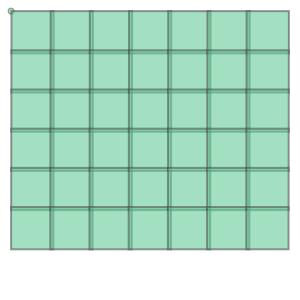

In [6]:
tiles_shifted_shapely = [numpy_shape_to_shapely(s) for s in shifted_tiles]
origin = Point(0,0)
GeometryCollection((origin, GeometryCollection(tiles_shifted_shapely)))

## Build the mosaic array that will stich each pos

### A version with non uniform chunk that match the size of the sum of tiles


In [28]:
mosaic_chunk_size = (1024, 1024)
chunks = normalize_chunks(mosaic_chunk_size, shape=stitched_shape)
print(chunks)
chunk_boundaries = list(get_chunk_coordinates(stitched_shape, mosaic_chunk_size))
print(chunk_boundaries)

((1024, 1024, 838), (1024, 1024, 1024, 293))
[((0, 1024), (0, 1024)), ((0, 1024), (1024, 2048)), ((0, 1024), (2048, 3072)), ((0, 1024), (3072, 3365)), ((1024, 2048), (0, 1024)), ((1024, 2048), (1024, 2048)), ((1024, 2048), (2048, 3072)), ((1024, 2048), (3072, 3365)), ((2048, 2886), (0, 1024)), ((2048, 2886), (1024, 2048)), ((2048, 2886), (2048, 3072)), ((2048, 2886), (3072, 3365))]


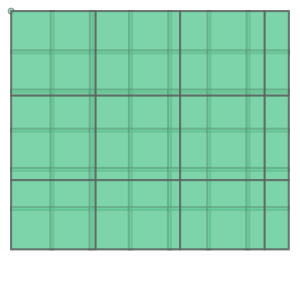

In [29]:
chunk_shapes = list(map(get_rect_from_chunk_boundary, chunk_boundaries))
chunks_shapely = [numpy_shape_to_shapely(c) for c in chunk_shapes]

GeometryCollection([origin, 
                    GeometryCollection(tiles_shifted_shapely), 
                    GeometryCollection(chunks_shapely),])

###  A version with uniform chunk size that oversize the sum of tiles

In [11]:
nx, ny = np.ceil(np.array(stitched_shape) / (mosaic_chunk_size)).astype(int)
chunks = ((mosaic_chunk_size[0],)*nx, (mosaic_chunk_size[1],)*ny)
print(chunks)
chunk_boundaries = list(get_chunk_coordinates2(*chunks))
print(chunk_boundaries)

((1024, 1024, 1024), (1024, 1024, 1024, 1024))
[((0, 1024), (0, 1024)), ((0, 1024), (1024, 2048)), ((0, 1024), (2048, 3072)), ((0, 1024), (3072, 4096)), ((1024, 2048), (0, 1024)), ((1024, 2048), (1024, 2048)), ((1024, 2048), (2048, 3072)), ((1024, 2048), (3072, 4096)), ((2048, 3072), (0, 1024)), ((2048, 3072), (1024, 2048)), ((2048, 3072), (2048, 3072)), ((2048, 3072), (3072, 4096))]


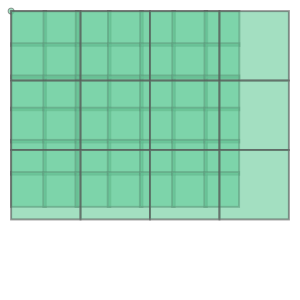

In [12]:
chunk_shapes = list(map(get_rect_from_chunk_boundary, chunk_boundaries))
chunks_shapely = [numpy_shape_to_shapely(c) for c in chunk_shapes]

GeometryCollection([origin, 
                    GeometryCollection(tiles_shifted_shapely), 
                    GeometryCollection(chunks_shapely),])

In [30]:
# Loop over shapely tiles to attach the transform matrix to them and the tile image object
tiles_infos = []
im_filter = 5
cpt = 0
roi = 1
img_names = list_images(metadata)
for tile_shifted_shapely, tile_dask_object, transform in zip(tiles_shifted_shapely, img_names, transforms_with_shift):
    tiles_infos += [{'shapely': tile_shifted_shapely, 
                     'lazy_image': {'zarr_path': '../../Notebooks/Est_map_40x_2_normalized.zarr', 'roi': roi, 'tile': cpt, 'channel': im_filter}, 
                     'transform':transform}]
    cpt += 1
    
    
# Loop over target tiles (large chunks) to add their boundarie informations
large_chunks_infos = []
for chunk_shapely, chunk_boundary  in zip(chunks_shapely, chunk_boundaries):
    large_chunks_infos += [{'shapely': chunk_shapely, 
                            'chunk_boundary': chunk_boundary}]

In [31]:
# Now we need to find intersection of new big tiles and small microscope tiles 
# to loade them only when needed
chunk_tiles = find_chunk_tile_intersections(tiles_infos, large_chunks_infos)

In [32]:
_fuse_func=partial(fuse_func, 
                   load_tile_func=mmzarr_load_one_tile,
                   dtype=np.uint8)

res = dask.array.map_blocks(_fuse_func,
                            chunk_tiles,
                            chunks=chunks,
                            dtype=np.uint16)

res

dask.array<fuse_func, shape=(2886, 3365), dtype=uint16, chunksize=(1024, 1024), chunktype=numpy.ndarray>

In [33]:
with ProgressBar():
    mosaic = res.compute()

[########################################] | 100% Completed | 912.31 ms


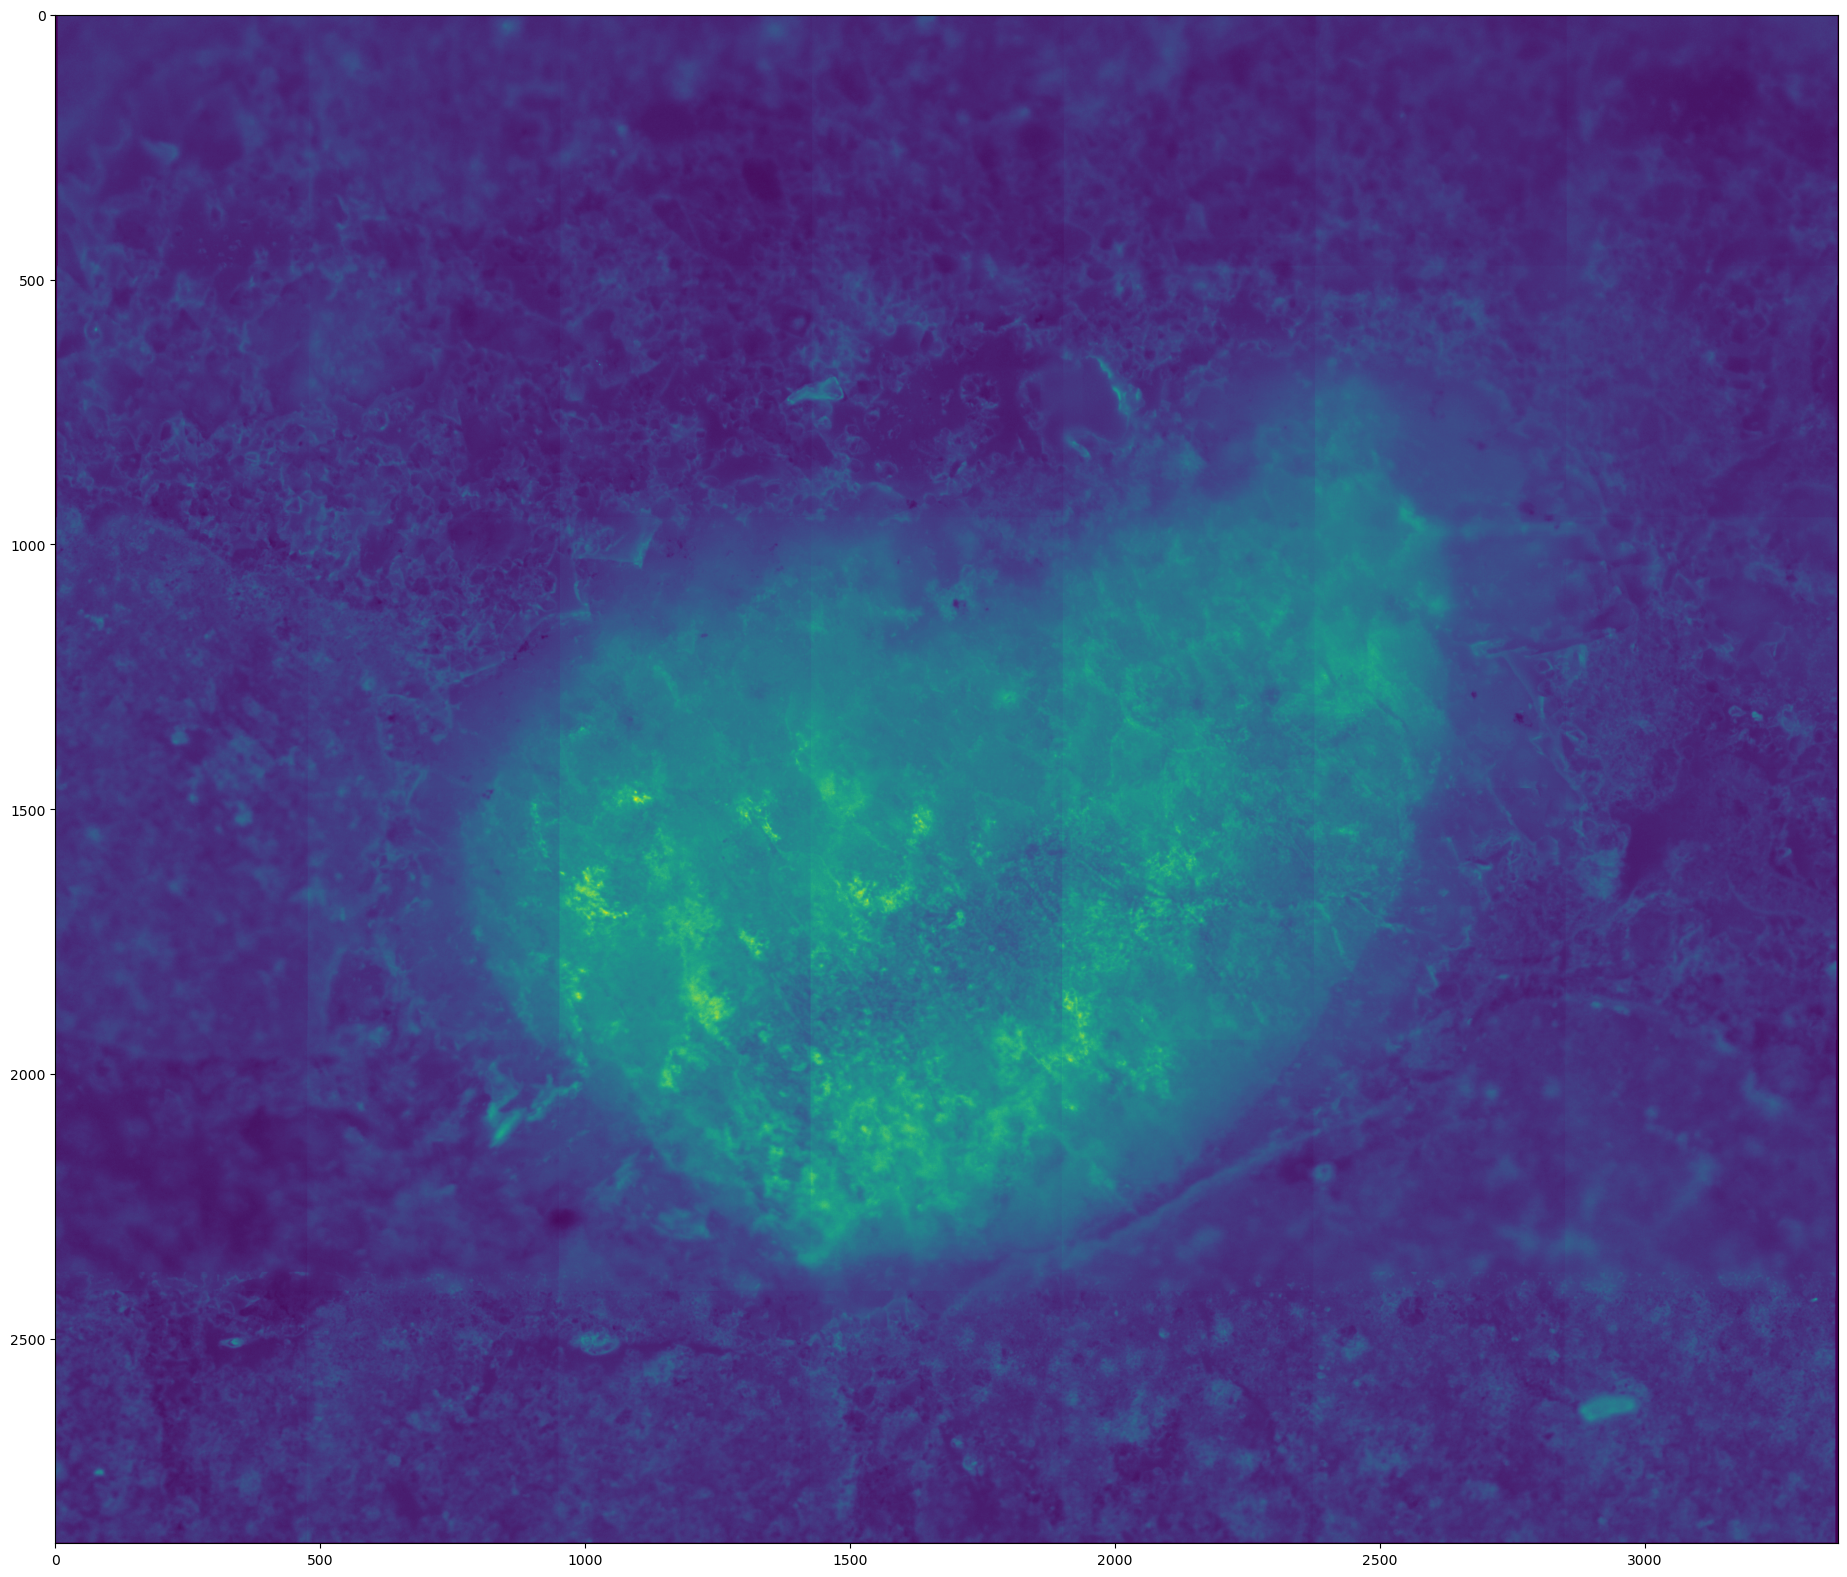

In [34]:

import matplotlib.pyplot as plt

plt.figure(figsize=(23, 23))
plt.imshow(mosaic)